In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
train, test = tfds.load('mnist', as_supervised=True, shuffle_files=True, split=['train', 'test'])

In [ ]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 256., label
def y_is_x(image, label):
    return image, image

train = train.map(normalize_img)
train = train.map(y_is_x)
train = train.batch(128)

    

### First we create a sampling layer to sample the codings

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return (keras.backend.random_normal(tf.shape(log_var)) * 
            keras.backend.exp(log_var / 2) + mean)

### Now we create the model

In [ ]:
codings_size = 10

inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z) # u
codings_log_var = keras.layers.Dense(codings_size)(z) # y
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])


In [ ]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)

variational_decoder = keras.Model(
    inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

### Now we compute loss and compile the model

In [ ]:
latent_loss = -0.5 * keras.backend.sum(
    1 + codings_log_var - keras.backend.exp(codings_log_var)
    - keras.backend.square(codings_mean), axis=-1)
# Compute mean over the batch, then divide by 784 to make to scale
# with the reconsutruction loss 
# (Keras cross entropy loss takes average rather than sum)
variational_ae.add_loss(keras.backend.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
history = variational_ae.fit(train, epochs=1)

469/469 [==============================] - 15s 32ms/step - loss: 0.2208


## Generated Digits

#### After 1 epoch

In [ ]:
codings = tf.random.normal(shape=[5, codings_size])
images = variational_decoder(codings).numpy()

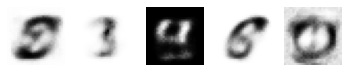

In [ ]:
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

#### After 50 epochs

In [ ]:
history = variational_ae.fit(train, epochs=50)

Epoch 1/50
469/469 [==============================] - 10s 22ms/step - loss: 0.1759
Epoch 2/50
469/469 [==============================] - 9s 20ms/step - loss: 0.1645
Epoch 3/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1592
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1559
Epoch 5/50
469/469 [==============================] - 9s 20ms/step - loss: 0.1537
Epoch 6/50
469/469 [==============================] - 10s 20ms/step - loss: 0.1519
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1505
Epoch 8/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1494
Epoch 9/50
469/469 [==============================] - 10s 22ms/step - loss: 0.1483
Epoch 10/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1474
Epoch 11/50
469/469 [==============================] - 11s 22ms/step - loss: 0.1466
Epoch 12/50
469/469 [==============================] - 10s 22ms/step - loss: 0.1459
Epo

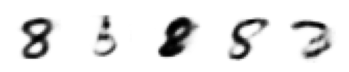

In [ ]:
# Same sample as before
images = variational_decoder(codings).numpy()
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

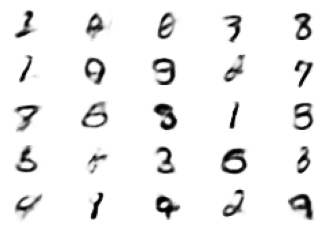

In [ ]:
# new sample
codings = tf.random.normal(shape=[25, codings_size])
images = variational_decoder(codings).numpy()
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i], cmap='binary')
    plt.axis("off")

In [5]:
print("Pushing Commit from Colab")

Pushing Commit from Colab
